# Punctuation prediction using BLSTM model

## Installing requirements (please install [pytorch](https://pytorch.org/get-started/locally/) compatible with your cuda version before)

In [ ]:
!pip install numpy
!pip install pandas
!pip install fasttext
!pip install pytorch-lightning
!pip install scikit-learn
!pip install matplotlib
!pip install seaborn

## Check your cuda and gpu

In [1]:
!nvidia-smi

Thu Dec 29 12:34:45 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.161.03   Driver Version: 470.161.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:0B:00.0  On |                  N/A |
| 30%   54C    P0   118W / 350W |    835MiB / 24245MiB |      9%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Imports and utility functions for the embedding

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import pytorch_lightning as pl
from pytorch_lightning import LightningModule
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
import numpy as np
import pandas as pd
import fasttext

In [3]:
def word_to_id(seq):
    word2id = {}

    for word in seq:
        if word not in word2id:
            word2id[word] = len(word2id)
    return word2id

def get_ids(sentence, word2id):
    ids = []
    for word in sentence:
        if word in word2id:
            ids.append(word2id[word])
        else:
            ids.append(0)
    return torch.tensor(ids, dtype= torch.long)

def get_embeddings(word2id, embedding_dim, embedding_file):
    ft = fasttext.load_model(embedding_file)
    embedding_matrix = np.zeros((len(word2id), embedding_dim))
    
    for word,i in word2id.items():
        embedding_matrix[i] = ft[word]
    return embedding_matrix

## Model architecture definition

In [4]:
class LSTMModel(LightningModule):
    def __init__(self, embedding_matrix, hidden_size, output_size, num_layers=1, bidirectional=True, loss_weights=None):
        super().__init__()

        self.hidden_dim = hidden_size

        self.embedding = nn.Embedding(embedding_matrix.shape[0], embedding_matrix.shape[1], _weight=torch.from_numpy(embedding_matrix))
        self.lstm = nn.LSTM(embedding_dim, hidden_size,num_layers=num_layers, dropout=0.3, bidirectional=bidirectional, batch_first=True)
        self.dropout = nn.Dropout(0.2)
        
        if bidirectional:
            self.fc1 = nn.Linear(2*hidden_size, 3*hidden_size)
            self.fc2 = nn.Linear(3*hidden_size, output_size)
        else:
            self.fc1 = nn.Linear(hidden_size, 2*hidden_size)
            self.fc2 = nn.Linear(2*hidden_size, output_size)
        
        self.relu = nn.ReLU()

        if loss_weights is None:
            self.loss_function = nn.NLLLoss()
        else:
            self.loss_function = nn.NLLLoss(weight=loss_weights)

        self.lr = 0.01

    def forward(self, input):        
        x = self.embedding(input.unsqueeze(0))
        x, _  = self.lstm(x)
        x = self.fc1(x)
        x = self.dropout(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = F.log_softmax(x, dim=2)
        return x

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=self.lr)
        return optimizer

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.loss_function(y_hat[0], y)
        return loss

## Reading the dataset

In [5]:
words_seq = []
labels_seq = []
for i in range(9):
    df = pd.read_csv(f'./preprocessed_wikitext/train{i}-10.csv').dropna()
    words_seq += df['words'].to_list()
    labels_seq += df['labels'].to_list()
    print(f'./preprocessed_wikitext/train{i}-10.csv')
    del df

./preprocessed_wikitext/train0-10.csv
./preprocessed_wikitext/train1-10.csv
./preprocessed_wikitext/train2-10.csv
./preprocessed_wikitext/train3-10.csv
./preprocessed_wikitext/train4-10.csv
./preprocessed_wikitext/train5-10.csv
./preprocessed_wikitext/train6-10.csv
./preprocessed_wikitext/train7-10.csv
./preprocessed_wikitext/train8-10.csv


In [6]:
len(words_seq)

80976257

In [7]:
special_labels = {',': 'I-COMMA',
                  '.': 'I-DOT',
                  '?': 'I-QMARK',
                  '!': 'I-EMARK',
                  ':': 'I-COLON',
                  ';': 'I-SEMICOLON'}
normal_label = 'O'
labels_set = list(special_labels.values()) + [normal_label]
label2id = {k:i for i, k in enumerate(labels_set)}
id2label = {i:k for i, k in enumerate(labels_set)}

## Transforming each word to 300d vector using embedding

In [8]:
embedding_file = './cc.en.300.bin'
embedding_dim = 300

word2id = word_to_id(words_seq)
embedding_matrix = get_embeddings(word2id, embedding_dim, embedding_file)

In [9]:
word_id_seq = get_ids(words_seq, word2id) #get_idsreturns tensor
del words_seq
label_id_seq = get_ids(labels_seq, label2id)
del labels_seq

## Using weights, we can say which labels are more important to us. For example, 'O' is not that important, and 'I-DOT' is more interesting for us.

In [10]:
count = label_id_seq.unique(return_counts=True)
weights = 1 - count[1] / torch.sum(count[1])

## Making batches with 200 word each. This will not effect the model at all. But helps to speed up the process.

In [11]:
seq_length = 200

train_set = TensorDataset(word_id_seq, label_id_seq)
train_loader = DataLoader(train_set, batch_size=seq_length)

In [12]:
tagger = LSTMModel(embedding_matrix=embedding_matrix,
                   hidden_size=32,
                   output_size=len(labels_set),
                   bidirectional=True,
                   loss_weights = weights
                   )
tagger.float()

/home/mostafa/anaconda3/lib/python3.9/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


LSTMModel(
  (embedding): Embedding(263856, 300)
  (lstm): LSTM(300, 32, batch_first=True, dropout=0.3, bidirectional=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=64, out_features=96, bias=True)
  (fc2): Linear(in_features=96, out_features=7, bias=True)
  (relu): ReLU()
  (loss_function): NLLLoss()
)

## Training bins 1 to 9. 

In [13]:
trainer = pl.Trainer(max_epochs=4, gpus=1, default_root_dir='./blstm_models/8/')

/home/mostafa/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:441: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [14]:
tagger.unfreeze()
tagger.train()

LSTMModel(
  (embedding): Embedding(263856, 300)
  (lstm): LSTM(300, 32, batch_first=True, dropout=0.3, bidirectional=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=64, out_features=96, bias=True)
  (fc2): Linear(in_features=96, out_features=7, bias=True)
  (relu): ReLU()
  (loss_function): NLLLoss()
)

In [15]:
trainer.fit(tagger, train_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type      | Params
--------------------------------------------
0 | embedding     | Embedding | 79.2 M
1 | lstm          | LSTM      | 85.5 K
2 | dropout       | Dropout   | 0     
3 | fc1           | Linear    | 6.2 K 
4 | fc2           | Linear    | 679   
5 | relu          | ReLU      | 0     
6 | loss_function | NLLLoss   | 0     
--------------------------------------------
79.2 M    Trainable params
0         Non-trainable params
79.2 M    Total params
316.997   Total estimated model params size (MB)
/home/mostafa/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 24 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=4` reached.


## Save the model checkpoint

In [16]:
trainer.save_checkpoint('./blstm_models/8/blstm_model_4_eps.ckpt')

## Testing on the last bin of the dataset

In [17]:
tagger.freeze()
tagger.eval()

LSTMModel(
  (embedding): Embedding(263856, 300)
  (lstm): LSTM(300, 32, batch_first=True, dropout=0.3, bidirectional=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=64, out_features=96, bias=True)
  (fc2): Linear(in_features=96, out_features=7, bias=True)
  (relu): ReLU()
  (loss_function): NLLLoss()
)

In [18]:
df = pd.read_csv('./preprocessed_wikitext/train9-10.csv')
test_words_seq = df['words'].to_list()
test_labels_seq = df['labels'].to_list()
del df

In [19]:
test_word_id_seq = get_ids(test_words_seq, word2id)
del test_words_seq
test_label_id_seq = get_ids(test_labels_seq, label2id)
del test_labels_seq

In [20]:
seq_length = 200

test_set = TensorDataset(test_word_id_seq, test_label_id_seq)
test_loader = DataLoader(test_set, batch_size=seq_length)

In [21]:
tagger.cuda()

LSTMModel(
  (embedding): Embedding(263856, 300)
  (lstm): LSTM(300, 32, batch_first=True, dropout=0.3, bidirectional=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=64, out_features=96, bias=True)
  (fc2): Linear(in_features=96, out_features=7, bias=True)
  (relu): ReLU()
  (loss_function): NLLLoss()
)

In [22]:
preds= []
for data in test_loader:
    preds.append(tagger(data[0].cuda()))

In [23]:
test_preds = []
for scores in preds:
    scores = scores[0].detach().cpu().numpy()
    scores = scores.argmax(axis=-1)
    for score in scores:
        test_preds.append(score)

In [24]:
true_labels = test_label_id_seq.numpy()

In [25]:
test_preds_label_list = [*map(id2label.get, test_preds)]
true_label_list = [*map(id2label.get, true_labels)]

## Evaluation

In [26]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

In [27]:
cm = confusion_matrix(y_true=true_label_list, y_pred=test_preds_label_list, labels=labels_set)
cm

array([[ 257295,   13355,       0,       0,       0,       0,  226052],
       [  40013,  262077,       0,       0,       0,       0,   56264],
       [    126,     355,       0,       0,       0,       0,     596],
       [    296,     389,       0,       0,       0,       0,     818],
       [   4749,    3856,       0,       0,       0,       0,    8446],
       [   8573,     708,       0,       0,       0,       0,    9453],
       [ 682427,  125097,       0,       0,       0,       0, 7333193]])

### Normalizing the confusion matrix

In [28]:
sum = np.sum(cm, axis=1)
sum = np.expand_dims(sum, axis=1)

In [29]:
nor_cm = (cm/sum)
nor_cm

array([[0.51800677, 0.02688735, 0.        , 0.        , 0.        ,
        0.        , 0.45510588],
       [0.11165775, 0.7313355 , 0.        , 0.        , 0.        ,
        0.        , 0.15700676],
       [0.11699164, 0.32961931, 0.        , 0.        , 0.        ,
        0.        , 0.55338904],
       [0.19693945, 0.2588157 , 0.        , 0.        , 0.        ,
        0.        , 0.54424484],
       [0.27851739, 0.22614509, 0.        , 0.        , 0.        ,
        0.        , 0.49533752],
       [0.45761717, 0.03779225, 0.        , 0.        , 0.        ,
        0.        , 0.50459058],
       [0.08382886, 0.01536683, 0.        , 0.        , 0.        ,
        0.        , 0.90080431]])

In [30]:
nor_cm.sum(axis=1)

array([1., 1., 1., 1., 1., 1., 1.])

Text(114.0, 0.5, 'True Label')

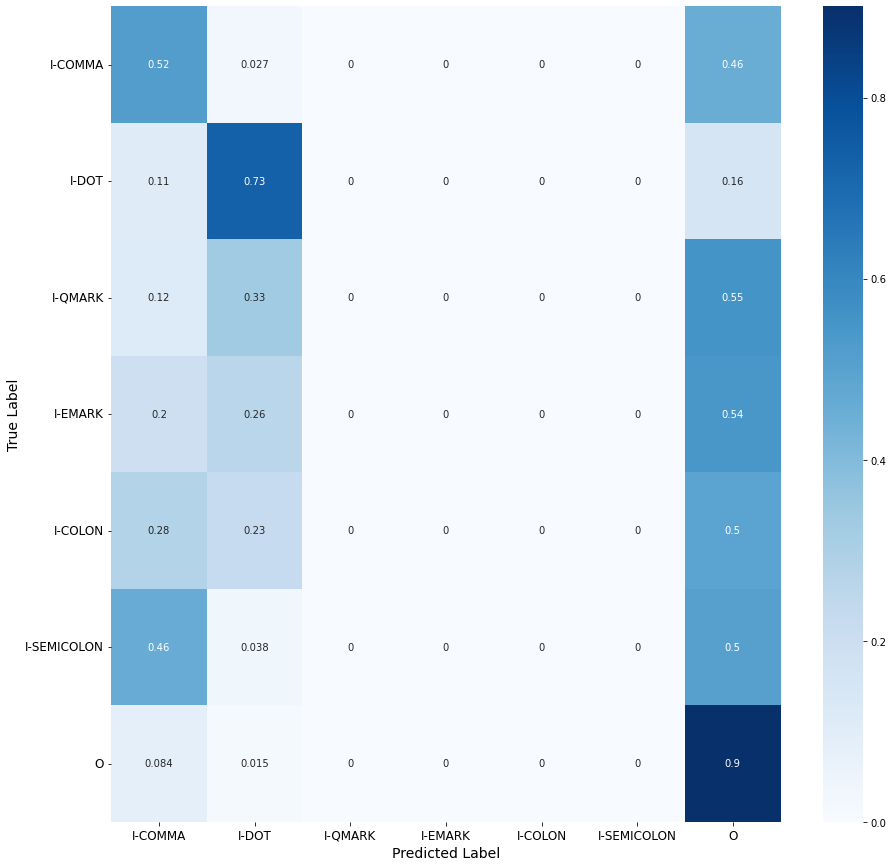

In [31]:
plot_labels = labels_set

fig, ax = plt.subplots(figsize=(15, 15))

sns.heatmap(nor_cm,
            ax=ax, 
            annot=True,
            cmap='Blues', 
            xticklabels=plot_labels,
            yticklabels=plot_labels)
plt.yticks(rotation=0,size=12)
plt.xticks(size=12)
ax.set_xlabel('Predicted Label',size=14)
ax.set_ylabel('True Label',size=14)